In [0]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pymc3 as pm

# Trials

given rating of 0 - 5, at prequake, quake, postquake of a single site

In [0]:
n = 100

probs_pre = np.array([0.8, 0.2, 0, 0, 0, 0])
probs_quake = np.array([0.0, 0, 0, 0, 0.2, 0.8])
probs_post = np.array([0, 0, 0.3, 0.2, 0.4, 0.1])

counts_pre = np.random.multinomial(n, probs_pre)
counts_quake = np.random.multinomial(n, probs_quake)
counts_post = np.random.multinomial(n/2, probs_post)

#Convert generated counts to raw scores
def count_to_score(counts):
  scores = np.array([])
  score = 0
  for i in counts:
    scores = np.append(scores, i * [score])
    score += 1
  return scores

scores_pre = count_to_score(counts_pre)
scores_quake = count_to_score(counts_quake)
scores_post = count_to_score(counts_post)

## Sampling
ideas from https://docs.pymc.io/notebooks/updating_priors.html



In [0]:
# with pm.Model() as dirchlet_multinomial:
#     probs = pm.Dirichlet('probs', a=np.ones(6))  # flat prior
#     counts = pm.Multinomial('scores', n=n, p=probs, observed=counts_quake)
#     trace = pm.sample(1000)
    
# pm.plot_posterior(trace);

In [0]:
def init_model(D):
  with pm.Model() as model_init:
    prior = pm.HalfNormal('mu', sd=1)
    likelihood = pm.Normal('likelihood', mu=prior, sd=1, observed=D)
    trace = pm.sample(1500, chains=1)
    
  return trace

In [0]:
trace = init_model(scores_pre)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1983.50it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6803525140283764, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


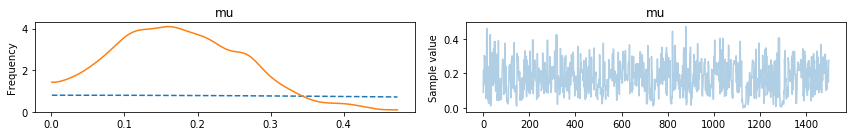

In [0]:
pm.traceplot(trace, priors=[pm.HalfNormal.dist(sd=1)]);

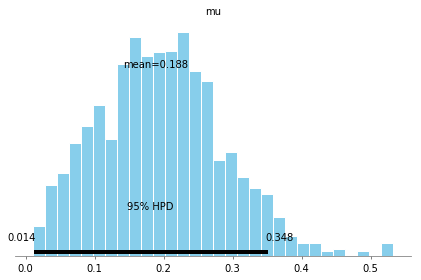

In [0]:
pm.plot_posterior(trace);

In [0]:
def from_posterior(param, samples, return_dist=False):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[0], x, [5]])
    y = np.concatenate([[0], y, [0]])
    
    if return_dist:
      return pm.Interpolated.dist(x, y)
      
    return pm.Interpolated(param, x, y)

In [0]:
def update_prior(D, trace):
  with pm.Model() as model:
    # Priors are posteriors from previous iteration
    prior = from_posterior('mu', trace['mu'])

    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('likelihood', mu=prior, sd=1, observed=D)

    # draw 10000 posterior samples
    trace = pm.sample(1500, chains=2)
    
  return trace

In [0]:
trace = init_model(scores_pre)

traces = [trace]

for D in [scores_quake, scores_post]:

    traces.append(update_prior(D, traces[-1]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1822.39it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1445.12it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1670.12it/s]


Posterior distributions of 3 time points.


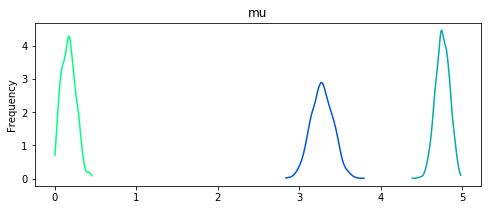

In [0]:
print('Posterior distributions of ' + str(len(traces)) + ' time points.')
cmap = mpl.cm.winter
for param in ['mu']:
    plt.figure(figsize=(8, 3))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    #plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

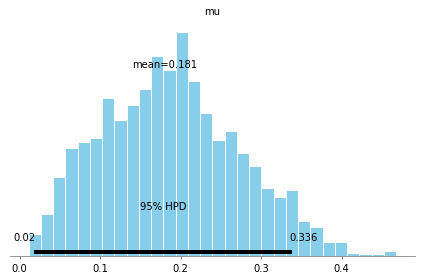

In [0]:
pm.plot_posterior(traces[0]);

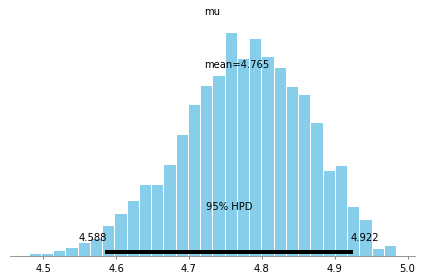

In [0]:
pm.plot_posterior(traces[1]);

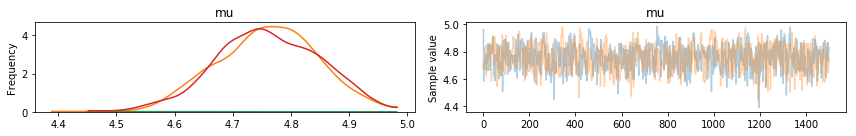

In [0]:
pm.traceplot(traces[1], priors=[from_posterior('mu', traces[0]['mu'], return_dist=True)]);

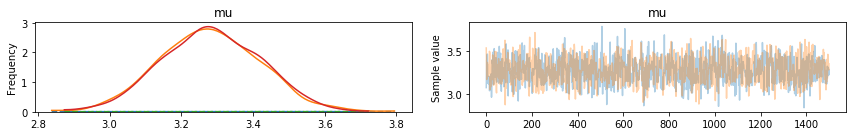

In [0]:
pm.traceplot(traces[2], priors=[from_posterior('mu', traces[1]['mu'], return_dist=True)]);

TypeError: ignored

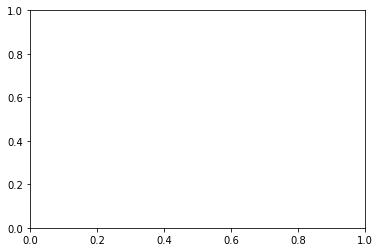

In [0]:
plt.plot(from_posterior('mu', traces[1]['mu'], return_dist=True))

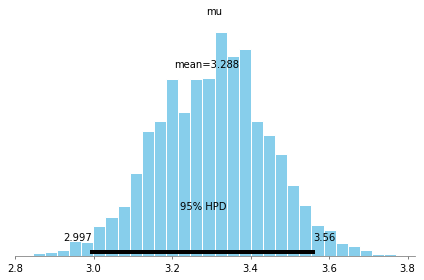

In [0]:
pm.plot_posterior(traces[2]);

# Conjugate Model

 Normal-inverse-Gamma (NIG) prior
 
from https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf, https://stackoverflow.com/questions/53211277/updating-model-on-pymc3-with-new-observed-data, https://en.wikipedia.org/wiki/Conjugate_prior


In [0]:
# prior
mu_0 = scores_pre.mean()
nu_0 = scores_pre.shape[0]
alpha_0 = nu_0/2
beta_0 = nu_0 * scores_pre.var() / 2

In [0]:
# # prior
# mu_0 = 57.0
# nu_0 = 80
# alpha_0 = 40
# beta_0 = alpha*5.42**2

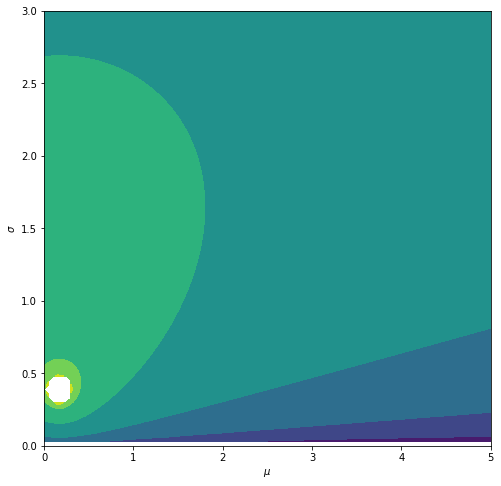

In [0]:
# points to compute likelihood at
mu_grid, sd_grid = np.meshgrid(np.linspace(0, 5, 101), 
                               np.linspace(0, 3, 101))

# mu_grid, sd_grid = np.meshgrid(np.linspace(47, 67, 101), 
#                                np.linspace(4, 8, 101))

# normal ~ N(X | mu_0, sigma/sqrt(nu))
logN = stats.norm.logpdf(x=mu_grid, loc=mu_0, scale=sd_grid/np.sqrt(nu_0))

# inv-gamma ~ IG(sigma^2 | alpha, beta)
logIG = stats.invgamma.logpdf(x=sd_grid**2, a=alpha_0, scale=beta_0)

# full log-likelihood
logNIG = logN + logIG

# actually, we'll plot the -log(-log(likelihood)) to get nicer contour
plt.figure(figsize=(8,8))
plt.contourf(mu_grid, sd_grid, -np.log(-logNIG))
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.show()

### updating parameters

In [0]:
# precompute some helpful values
n = scores_quake.shape[0]
mu_y = scores_quake.mean()

In [0]:
# updated NIG parameters
mu_n = (nu_0*mu_0 + n*mu_y)/(nu_0 + n)
nu_n = nu_0 + n
alpha_n = alpha_0 + n/2
beta_n = beta_0 + 0.5*(n*nu_0/nu_n)*(mu_y - mu_0)**2 + 0.5*np.square(scores_quake - mu_y).sum()

In [0]:
# np.random.seed(53211277)
# Y1 = np.random.normal(loc=62, scale=7.0, size=20)

# # precompute some helpful values
# n = Y1.shape[0]
# mu_y = Y1.mean()

# # updated NIG parameters
# mu_n = (nu_0*mu_0 + n*mu_y)/(nu_0 + n)
# nu_n = nu_0 + n
# alpha_n = alpha_0 + n/2
# beta_n = beta_0 + 0.5*(n*nu_0/nu_n)*(mu_y - mu_0)**2 + 0.5*np.square(Y1 - mu_y).sum()


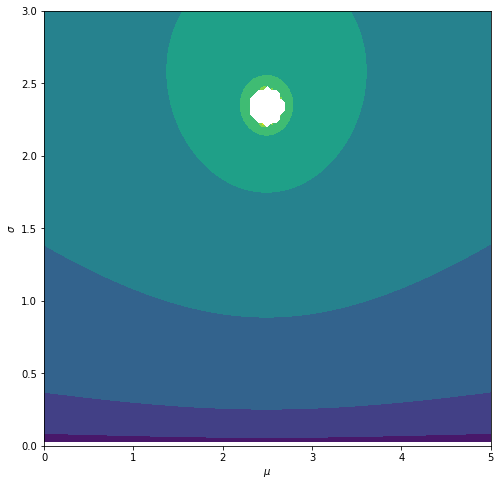

In [0]:
# normal ~ N(X | mu_0, sigma/sqrt(nu))
logN = stats.norm.logpdf(x=mu_grid, loc=mu_n, scale=sd_grid/np.sqrt(nu_n))

# inv-gamma ~ IG(sigma^2 | alpha, beta)
logIG = stats.invgamma.logpdf(x=sd_grid**2, a=alpha_n, scale=beta_n)

# full log-likelihood
logNIG = logN + logIG

# actually, we'll plot the -log(-log(likelihood)) to get nicer contour
plt.figure(figsize=(8,8))
plt.contourf(mu_grid, sd_grid, -np.log(-logNIG))
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.show()


## Wrap as a function

In [0]:
def define_conj_prior(D, plot=False):
  
  mu_0 = D.mean()
  nu_0 = D.shape[0]
  alpha_0 = nu_0/2
  beta_0 = nu_0 * D.var() / 2


  mu_grid, sd_grid = np.meshgrid(np.linspace(0, 5, 101), 
                                 np.linspace(0, 3, 101))


  logN = stats.norm.logpdf(x=mu_grid, loc=mu_0, scale=sd_grid/np.sqrt(nu_0))
  

  logIG = stats.invgamma.logpdf(x=sd_grid**2, a=alpha_0, scale=beta_0)


  logNIG = logN + logIG

  if plot:
    plt.figure(figsize=(8,8))
    plt.contourf(mu_grid, sd_grid, -np.log(-logNIG))
    plt.xlabel("$\mu$")
    plt.ylabel("$\sigma$")
    plt.show()
  
  return (mu_0, nu_0, alpha_0, beta_0)

  

def update_conj_prior(D, D_prior, plot=False):
  
  mu_0, nu_0, alpha_0, beta_0 = define_conj_prior(D_prior)
  
  n = D.shape[0]
  mu_n = D.mean()

  mu_n = (nu_0*mu_0 + n*mu_n)/(nu_0 + n)
  nu_n = nu_0 + n
  alpha_n = alpha_0 + n/2
  beta_n = beta_0 + 0.5*(n*nu_0/nu_n)*(mu_n - mu_0)**2 + 0.5*np.square(D - mu_n).sum()

  mu_grid, sd_grid = np.meshgrid(np.linspace(0, 5, 101), 
                               np.linspace(0, 3, 101))

  logN = stats.norm.logpdf(x=mu_grid, loc=mu_n, scale=sd_grid/np.sqrt(nu_n))

  logIG = stats.invgamma.logpdf(x=sd_grid**2, a=alpha_n, scale=beta_n)

  logNIG = logN + logIG


  if plot:
    plt.figure(figsize=(8,8))
    plt.contourf(mu_grid, sd_grid, -np.log(-logNIG))
    plt.xlabel("$\mu$")
    plt.ylabel("$\sigma$")
    plt.show()

  return (mu_n, nu_n, alpha_n, beta_n)


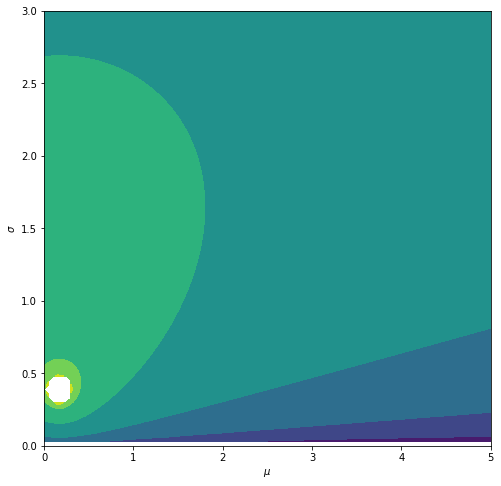

(0.17, 100, 50.0, 7.055)

In [0]:
define_conj_prior(scores_pre, plot=True)

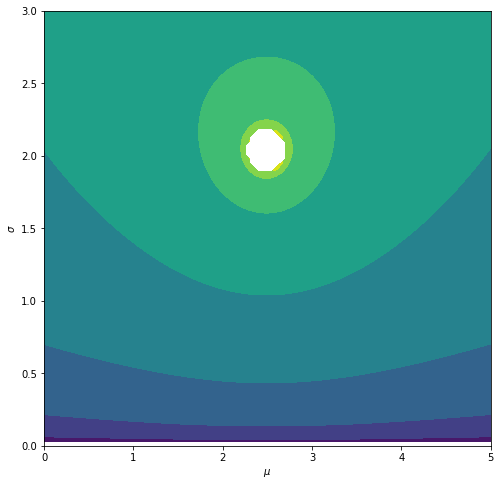

(2.4899999999999998, 200, 100.0, 418.4300000000002)

In [0]:
update_conj_prior(scores_quake, scores_pre, plot=True)

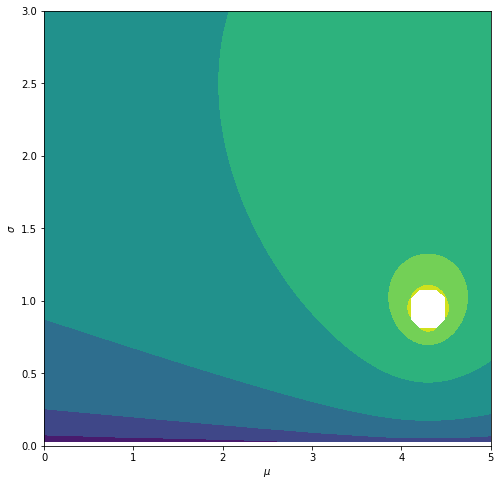

(4.3, 150, 75.0, 66.07999999999998)

In [0]:
update_conj_prior(scores_post, scores_quake, plot=True)

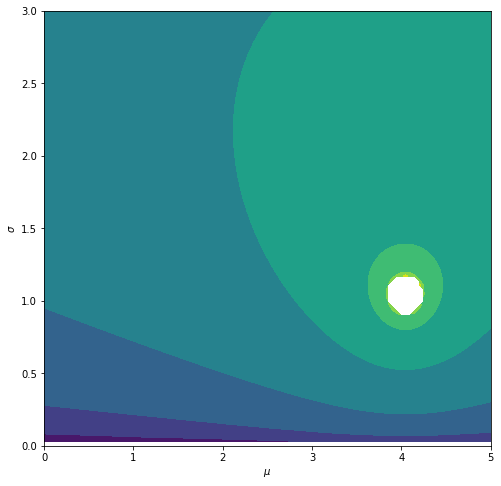

(4.045, 200, 100.0, 107.66687499999998)

In [0]:
update_conj_prior(np.append(scores_post, scores_post), scores_quake, plot=True)

# Multiple sites

Sites have different numbers (10, 100, 1000) scores. They are from the same time points (pre, quake, post).


(see more https://discourse.pymc.io/t/updating-multivariate-priors/2804/10)

In [0]:
def gen_samples(n, p):
  return count_to_score(np.random.multinomial(n, p))

In [0]:
n = [10, 100, 1000, 10000]
n_sites = len(n)

probs_pre = np.array([0.8, 0.2, 0, 0, 0, 0])
probs_quake = np.array([0.0, 0, 0, 0, 0.2, 0.8])
probs_post = np.array([0, 0, 0.3, 0.2, 0.4, 0.1])

scores_pre_ = [gen_samples(n[i], probs_pre) for i in range(n_sites)]
scores_quake_ = [gen_samples(n[i], probs_quake) for i in range(n_sites)]
scores_post_ = [gen_samples(n[i]/10, probs_post) for i in range(n_sites)]


In [0]:
traces = {}

for site in range(n_sites):
  traces[site] = [init_model(scores_pre_[site])]
  

for Ds in [scores_quake_, scores_post_]:
  
  for site in range(n_sites):
    traces[site].append(update_prior(Ds[site], traces[site][-1]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1898.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 2102.37it/s]
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5172689268937191, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1835.31it/s]
Only one chain was sampled, this makes it impossible

In [0]:
traces

{0: [<MultiTrace: 1 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>],
 1: [<MultiTrace: 1 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>],
 2: [<MultiTrace: 1 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>],
 3: [<MultiTrace: 1 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>,
  <MultiTrace: 2 chains, 1500 iterations, 2 variables>]}

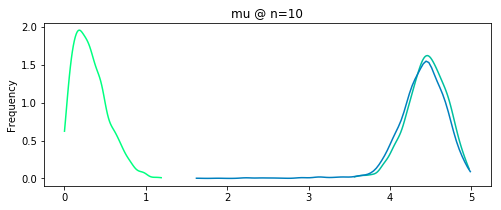

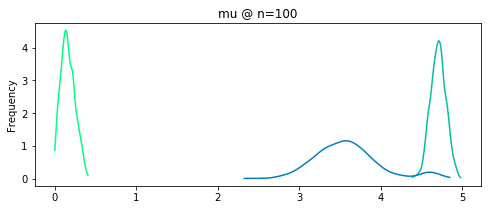

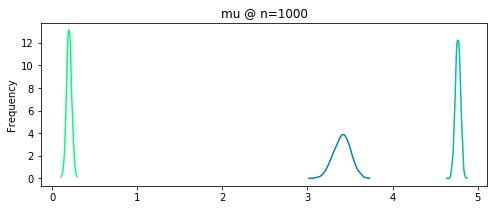

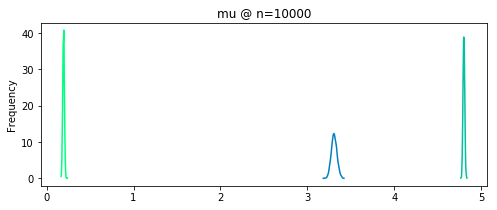

In [0]:
for site in range(n_sites):
  cmap = mpl.cm.winter
  trace_ = traces[site]
  plt.figure(figsize=(8, 3))
  for update_i, trace in enumerate(trace_):
      samples = trace['mu']
      smin, smax = np.min(samples), np.max(samples)
      x = np.linspace(smin, smax, 100)
      y = stats.gaussian_kde(samples)(x)
      plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
  #plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
  plt.ylabel('Frequency')
  plt.title('mu @ n='+str(n[site]))
  plt.show()

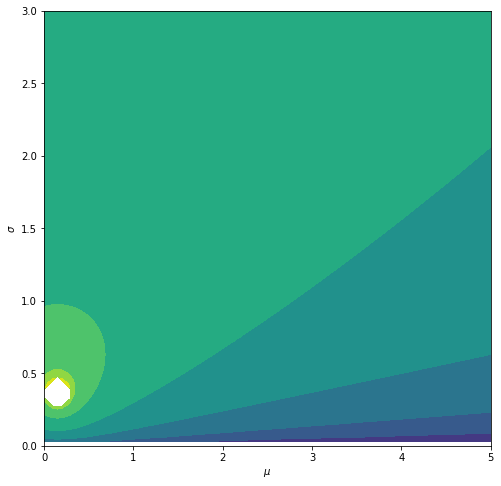

(0.15, 100, 50.0, 6.375)

In [0]:
define_conj_prior(scores_pre_[1], plot=True)

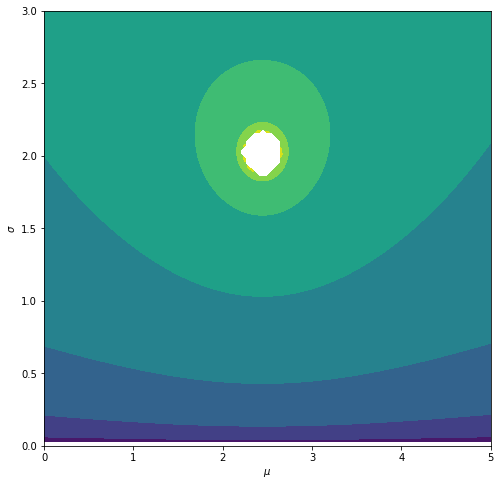

(2.445, 200, 100.0, 411.0218749999999)

In [0]:
update_conj_prior(scores_quake_[1], scores_pre_[1], plot=True)

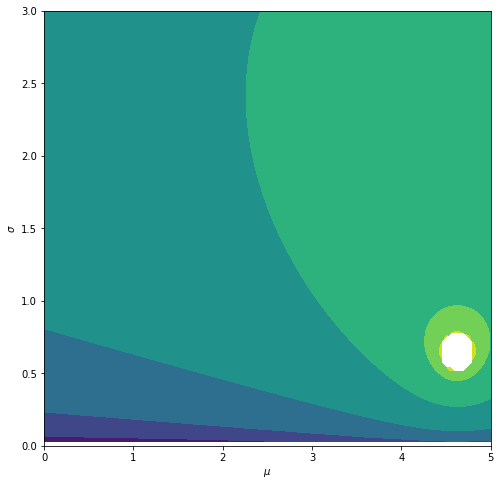

(4.627272727272727, 110, 55.0, 22.28148009015777)

In [0]:
update_conj_prior(scores_post_[1], scores_quake_[1], plot=True)